In [29]:
import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import inv, norm, det

import os
os.chdir('/home/kei/Desktop/dpp/')

from multiprocessing import Pool

import sampler.dpp as dpp
import sampler.mcdpp as mcdpp
import sampler.utils as utils

In [30]:
# currently only support cpu mode
flag_gpu = False

lmbd = 1e-4
nTrn = 4000
nTot = 5000
data = pd.read_csv('data/ailerons.txt')[:nTot].values
trnY = data[:nTrn, -1]
tstY = data[nTrn:, -1]
pairwise_dists = squareform(pdist(data[:,:-1], 'euclidean'))
L_0 = np.exp(-pairwise_dists ** 2 / 100 ** 2)
trnL_0 = L_0[:nTrn, :nTrn]

In [31]:
def kl_multi_gaussian(mu0, S0, mu1, S1):
    
    assert(len(mu0)==len(mu1))
    assert(S0.shape==S1.shape)
    
    k = len(mu0)
    invS1 = inv(S1)
    tr = sum(invS1*S0)
    quad = (mu1-mu0) @ invS1 @ (mu1-mu0)
    logdet = np.log(det(S1)/det(S0))
    
    return 1/2 * (tr + quad - k + logdet)

In [32]:
def kl_gaussian(mu0, sigsq0, mu1, sigsq1):
    return 1/2 * (np.log(sigsq1)-np.log(sigsq0) + sigsq0/sigsq1 - 1 + (mu0-mu1)**2/sigsq1)

def kl_gaussian_vec(vec):
    [mu0, sigsq0, mu1, sigsq1] = list(vec)
    return kl_gaussian(mu0, sigsq0, mu1, sigsq1)

In [33]:
kl_gaussian_vec([0,1,0,1.1])

0.00220054444761697

# Full GP

In [34]:
sigma2_0 = nTrn*lmbd
inv_mat_0 = inv(trnL_0 + sigma2_0 * np.identity(nTrn))
alpha_0 = inv_mat_0 @ trnY

In [35]:
# correct the scaling factor
scale = trnY.var()/sigma2_0
for i in range(100):
    dscale = - nTrn/(2*scale) + 1/(2*scale**2) * trnY @ inv_mat_0 @ trnY
    ddscale = (nTrn/2*scale**2) - 1/(scale**3) * trnY @ inv_mat_0 @ trnY
    scale -= 0.1*dscale/ddscale

In [36]:
dscale/ddscale

3.0751594601313973e-10

In [37]:
sigma2 = scale * sigma2_0
L = scale * L_0
trnL = scale * trnL_0

In [38]:
sigma2, trnY.var()

(9.006578963627065e-08, 1.6367094937499997e-07)

In [39]:
inv_mat = inv(trnL + sigma2 * np.identity(nTrn))
alpha = inv_mat @ trnY
Y_hat_full = L[:,:nTrn]@ alpha
Var_Y_hat_full = L - L[:,:nTrn] @ inv_mat @ L[:nTrn,:] + sigma2 * np.identity(L.shape[0])
error_full_trn = norm(Y_hat_full[:nTrn] - trnY)
error_full_tst = norm(Y_hat_full[nTrn:] - tstY)

In [40]:
kl_gaussian_vec([0,1e-8,1e-4,1e-8])

0.5

In [41]:
trnY.var()

1.6367094937499997e-07

In [42]:
Var_Y_hat_full[:3,:3]

array([[ 9.05691290e-08,  5.64946577e-14, -1.28352042e-10],
       [ 5.64946577e-14,  1.20709233e-07, -1.36779805e-14],
       [-1.28352042e-10, -1.36779805e-14,  9.33154415e-08]])

# Nystrom GP

In [43]:
k_group = [20,30,50,70,100,150]

In [44]:
def simulate_once(i):
    
    np.random.seed(i)

    error_unif = np.zeros((4, len(k_group)))
    error_dpp = np.zeros((4, len(k_group)))
    error_mcdpp = np.zeros((4, len(k_group)))

    kl_bound = np.zeros((3,len(k_group),))

    for k_idx in range(len(k_group)):
        k = k_group[k_idx]

        # Uniform sampling
        unif_smpl = np.random.permutation(nTrn)[:k]

        C = trnL[np.ix_(range(nTrn), unif_smpl)]
        W = C[np.ix_(unif_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_unif[0,k_idx] += np.trace(trnL - trnL_prime) #norm(trnL_prime - trnL, 'fro')

        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY) )
        Var_Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), unif_smpl)].T + sigma2 * np.identity(L.shape[0])

        error_unif[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_unif[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]
            ]).T
        error_unif[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()

        # DPP
        D, V = utils.get_eig(trnL_0, flag_gpu=flag_gpu)
        E = utils.get_sympoly(D, k, flag_gpu=flag_gpu)
        dpp_smpl  = dpp.sample(D, V, E=E, k=k, flag_gpu=flag_gpu)

        C = trnL[np.ix_(range(nTrn), dpp_smpl)]
        W = C[np.ix_(dpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_dpp[0,k_idx] += np.trace(trnL - trnL_prime) #norm(trnL_prime - trnL, 'fro')

        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), dpp_smpl)].T + sigma2 * np.identity(L.shape[0])
        error_dpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_dpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]
            ]).T
        error_dpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()
        
        #MC-DPP
        #too slow to wait mixing
        mcdpp_smpl  = mcdpp.sample(trnL_0, mix_step=nTrn, k=k, flag_gpu=flag_gpu, silent=True)

        C = trnL[np.ix_(range(nTrn), mcdpp_smpl)]
        W = C[np.ix_(mcdpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_mcdpp[0,k_idx] += np.trace(trnL - trnL_prime) #norm(trnL_prime - trnL, 'fro')

        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), mcdpp_smpl)].T + sigma2 * np.identity(L.shape[0])
        error_mcdpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_mcdpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]
            ]).T
        error_mcdpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()
        
        kl_bound[0,k_idx] += np.trace(trnL - trnL_prime)**2
        kl_bound[1,k_idx] += (1/4 * ( 1 - np.diag(Var_Y_hat)[nTrn:] / np.diag(Var_Y_hat_full)[nTrn:] )**2 ).mean()
        kl_bound[2,k_idx] += (1/2 * ( Y_hat_full[nTrn:] - Y_hat[nTrn:])**2 / np.diag(Var_Y_hat_full)[nTrn:]).mean()
        
    return [error_unif, error_dpp, error_mcdpp, kl_bound]

In [45]:
n_job = 6
with Pool(processes=6) as p:
    results = p.map(simulate_once, [i for i in range(n_job)])

In [46]:
error_unif = np.zeros((4, len(k_group)))
error_dpp = np.zeros((4, len(k_group)))
error_mcdpp = np.zeros((4, len(k_group)))
kl_bound = np.zeros((3,len(k_group),))

for r in results:
    error_unif += r[0]
    error_dpp += r[1]
    error_mcdpp += r[2]
    kl_bound += r[3]

# Plot

In [ ]:
%matplotlib inline

In [ ]:
kl_bound[1]

In [ ]:
kl_bound[2]

In [ ]:
error_mcdpp[3]

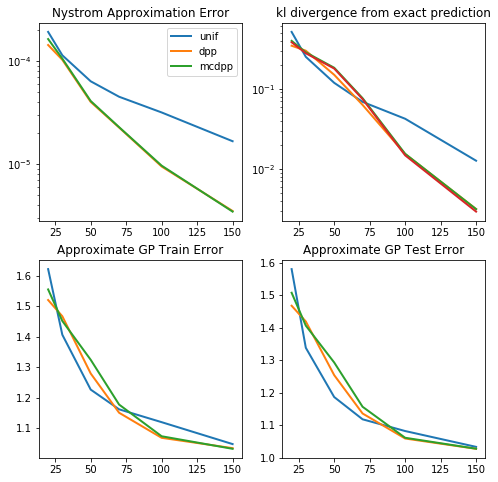

In [48]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title('Nystrom Approximation Error')
plt.plot(k_group, error_unif[0] / n_job, label='unif', lw=2)
plt.plot(k_group, error_dpp[0] / n_job, label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[0] / n_job, label='mcdpp', lw=2)
plt.yscale('log')
plt.legend()
#plt.savefig('fig/nystrom', bbox_inches='tight')

plt.subplot(2,2,2)
plt.title('kl divergence from exact prediction')
plt.plot(k_group, error_unif[3] / n_job, label='unif', lw=2)
plt.plot(k_group, error_dpp[3] / n_job, label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[3] / n_job, label='mcdpp', lw=2)
#plt.plot(k_group, kl_bound[0] / 4000**2/n_job, label='bound for mcdpp', lw=2)
#plt.plot(k_group, kl_bound[1] / n_job * 2, label='bound for mcdpp', lw=2)
plt.plot(k_group, kl_bound[2]/n_job, label='bound for mcdpp', lw=2)

plt.yscale('log')


plt.subplot(2,2,3)
plt.title('Approximate GP Train Error')
plt.plot(k_group, error_unif[1] / n_job/error_full_trn, label='unif', lw=2)
plt.plot(k_group, error_dpp[1] / n_job/error_full_trn, label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[1] / n_job/error_full_trn, label='mcdpp', lw=2)
#plt.yscale('log')
plt.subplot(2,2,4)
plt.title('Approximate GP Test Error')
plt.plot(k_group, error_unif[2] / n_job/error_full_tst, label='unif', lw=2)
plt.plot(k_group, error_dpp[2] / n_job/error_full_tst, label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[2] / n_job/error_full_tst, label='mcdpp', lw=2)
#plt.yscale('log')

plt.savefig('fig/gp_regression', bbox_inches='tight')

In [ ]:
# distribution of eigen values
D, V = utils.get_eig(trnL, flag_gpu=flag_gpu)
plt.plot(D)